**BUILDING A SEGMENTATION MODEL TO LOCALIZE TUMOR**

In [1]:
#imports the required packages
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D, Input
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
import scipy
import os
from skimage import io
import seaborn as sns
import cv2
import random
from matplotlib import pyplot 
import pandas as pd
import tensorflow.keras.backend as K
import numpy as np
np.random.seed(13)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#Changed to working directory to the location of the dataset and loaded the dataset description for local host.
os.chdir("..\kaggle_3m")
brain_df = pd.read_csv('data_frame.csv')

#For google colab
#brain_df = pd.read_csv('/content/drive/MyDrive/kaggle_3m/Gdrive.csv')
# Here we decided to drop unncessary coloums from the dataset
brain_df_train = brain_df.drop(columns=['Unnamed: 0', 'patient'], axis=1)
brain_df_train['diagnosis'] = brain_df['diagnosis'].apply(lambda x: str(x)) #changes the type of the values of the column to sting

brain_df_mask = brain_df_train[brain_df_train['diagnosis'] == '1']
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [9]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 224, img_w = 224, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

In [10]:
# lets create model now
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [11]:
input_shape = (224,224,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(14, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(14, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 28)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 56)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 112)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 224)

# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 112)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 56)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 28)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 14)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 224, 224, 14) 392         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 224, 224, 14) 56          conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 224, 224, 14) 1778        batch_normalization_26[0][0]     
____________________________________________________________________________________________

 **TRAINING SEGMENTATION MODEL**

In [6]:
# Define a custom loss function for ResUNet model
'''
actual link for refrence (https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)
'''
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [13]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss = binary_crossentropy, 
                  metrics = ['accuracy']
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )


In [14]:
h = seg_model.fit(train_data, 
                  epochs = 10, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/10
72/72 [==============================] - 378s 5s/step - loss: 0.2091 - accuracy: 0.9113 - val_loss: 0.1702 - val_accuracy: 0.9666

Epoch 00001: val_loss improved from inf to 0.17017, saving model to ResUNet-segModel-weights.hdf5


c:\users\hi\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
72/72 [==============================] - 364s 5s/step - loss: 0.0666 - accuracy: 0.9779 - val_loss: 0.0764 - val_accuracy: 0.9750

Epoch 00002: val_loss improved from 0.17017 to 0.07644, saving model to ResUNet-segModel-weights.hdf5
Epoch 3/10
72/72 [==============================] - 366s 5s/step - loss: 0.0567 - accuracy: 0.9802 - val_loss: 0.0619 - val_accuracy: 0.9779

Epoch 00003: val_loss improved from 0.07644 to 0.06192, saving model to ResUNet-segModel-weights.hdf5
Epoch 4/10
72/72 [==============================] - 365s 5s/step - loss: 0.0467 - accuracy: 0.9837 - val_loss: 0.0540 - val_accuracy: 0.9782

Epoch 00004: val_loss improved from 0.06192 to 0.05403, saving model to ResUNet-segModel-weights.hdf5
Epoch 5/10
72/72 [==============================] - 365s 5s/step - loss: 0.0397 - accuracy: 0.9858 - val_loss: 0.0477 - val_accuracy: 0.9816

Epoch 00005: val_loss improved from 0.05403 to 0.04766, saving model to ResUNet-segModel-weights.hdf5
Epoch 6/10
72/72 [======

In [15]:
# saving model achitecture in json file
seg_model_json = seg_model.to_json()
with open("ResUNet-seg-model.json", "w") as json_file:
    json_file.write(seg_model_json)
seg_model.save('segModel')

c:\users\hi\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: segModel\assets


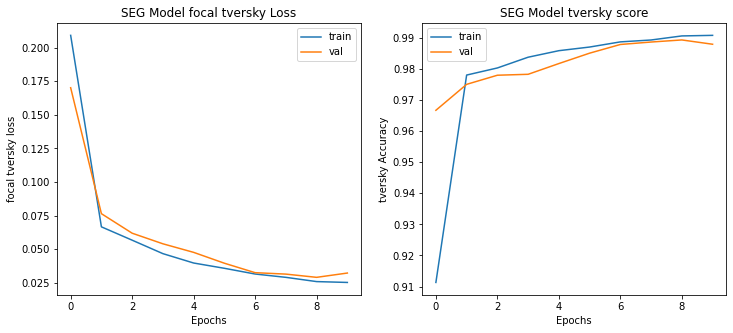

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [17]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

6/6 [==============================] - 6s 965ms/step - loss: 0.0365 - accuracy: 0.9858
Segmentation tversky is 98.58%


SEGMENTATION MODEL PREFORMACE
(COMBINING CLASSIFICATION AND SEGMENTAION MODEL BUILDING PIPELINE)

In [18]:
def prediction(test, model, model_seg):
    '''
    Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
    Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
    is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
    segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
    '''
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (224,224))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,224,224,3
        img = np.reshape(img, (1,224,224,3))
        
        #making prediction for tumor in image
        labels = []
        for m in TrainedModel:
            predicts = np.argmax(m.predict(img), axis=1)
            labels.append(predicts)
        is_defect = scipy.stats.mode(labels,axis=0)
        #is_defect = model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue
        
        #Creating a empty array of shape 1,224,224,1
        X = np.empty((1,224,224,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (224,224))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 224,224,3 to 1,224,224,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})


In [19]:
NasNet = tf.keras.models.load_model('my_firstModel')
MobileNet = tf.keras.models.load_model('my_secondModel')
MobileNetV2 = tf.keras.models.load_model('my_thirdModel')
EfficientNet = tf.keras.models.load_model('my_forthModel')
TrainedModel = [NasNet,MobileNet,MobileNetV2,EfficientNet] 

In [20]:
_, test = train_test_split(brain_df_train, test_size=0.15)

In [21]:
# making prediction
df_pred = prediction(test, TrainedModel, seg_model)
df_pred

image_path  \
0    ../kaggle_3m\TCGA_DU_7301_19911112/TCGA_DU_730...   
1    ../kaggle_3m\TCGA_DU_6404_19850629/TCGA_DU_640...   
2    ../kaggle_3m\TCGA_DU_6401_19831001/TCGA_DU_640...   
3    ../kaggle_3m\TCGA_DU_5874_19950510/TCGA_DU_587...   
4    ../kaggle_3m\TCGA_CS_6668_20011025/TCGA_CS_666...   
..                                                 ...   
585  ../kaggle_3m\TCGA_CS_4941_19960909/TCGA_CS_494...   
586  ../kaggle_3m\TCGA_CS_6186_20000601/TCGA_CS_618...   
587  ../kaggle_3m\TCGA_DU_5872_19950223/TCGA_DU_587...   
588  ../kaggle_3m\TCGA_HT_7881_19981015/TCGA_HT_788...   
589  ../kaggle_3m\TCGA_FG_7637_20000922/TCGA_FG_763...   

                                        predicted_mask  has_mask  
0    [[[[0.00374192], [0.0019871], [0.00111783], [0...         1  
1    [[[[0.00472593], [0.00245827], [0.00112525], [...         1  
2    [[[[0.00403053], [0.00217167], [0.00116169], [...         1  
3    [[[[0.00398704], [0.00218913], [0.00119963], [...         1  
4    [[[[0.00178924], [0.00235775], [0.00096521], [...         1  
..                                                 ...       ...  
585  [[[[0.00339237], [0.00106308], [0.00099373], [...         1  
586                                         No mask :)         0  
587  [[[[0.00191337], [0.00190645], [0.00088763], [...         1  
588                                         No mask :)         0  
589  [[[[0.0028643], [0.00434014], [0.00317878], [0...         1  

[590 rows x 3 columns]

In [22]:
# merging original and prediction df
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

image_path  \
0  ../kaggle_3m\TCGA_DU_7301_19911112/TCGA_DU_730...   
1  ../kaggle_3m\TCGA_DU_6404_19850629/TCGA_DU_640...   
2  ../kaggle_3m\TCGA_DU_6401_19831001/TCGA_DU_640...   
3  ../kaggle_3m\TCGA_DU_5874_19950510/TCGA_DU_587...   
4  ../kaggle_3m\TCGA_CS_6668_20011025/TCGA_CS_666...   
5  ../kaggle_3m\TCGA_CS_6669_20020102/TCGA_CS_666...   
6  ../kaggle_3m\TCGA_DU_6408_19860521/TCGA_DU_640...   
7  ../kaggle_3m\TCGA_DU_5871_19941206/TCGA_DU_587...   
8  ../kaggle_3m\TCGA_DU_7298_19910324/TCGA_DU_729...   
9  ../kaggle_3m\TCGA_HT_7693_19950520/TCGA_HT_769...   

                                           mask_path diagnosis  \
0  ../kaggle_3m\TCGA_DU_7301_19911112/TCGA_DU_730...         1   
1  ../kaggle_3m\TCGA_DU_6404_19850629/TCGA_DU_640...         0   
2  ../kaggle_3m\TCGA_DU_6401_19831001/TCGA_DU_640...         1   
3  ../kaggle_3m\TCGA_DU_5874_19950510/TCGA_DU_587...         1   
4  ../kaggle_3m\TCGA_CS_6668_20011025/TCGA_CS_666...         0   
5  ../kaggle_3m\TCGA_CS_6669_20020102/TCGA_CS_666...         0   
6  ../kaggle_3m\TCGA_DU_6408_19860521/TCGA_DU_640...         0   
7  ../kaggle_3m\TCGA_DU_5871_19941206/TCGA_DU_587...         1   
8  ../kaggle_3m\TCGA_DU_7298_19910324/TCGA_DU_729...         0   
9  ../kaggle_3m\TCGA_HT_7693_19950520/TCGA_HT_769...         1   

                                      predicted_mask  has_mask  
0  [[[[0.00374192], [0.0019871], [0.00111783], [0...         1  
1  [[[[0.00472593], [0.00245827], [0.00112525], [...         1  
2  [[[[0.00403053], [0.00217167], [0.00116169], [...         1  
3  [[[[0.00398704], [0.00218913], [0.00119963], [...         1  
4  [[[[0.00178924], [0.00235775], [0.00096521], [...         1  
5                                         No mask :)         0  
6  [[[[0.00352189], [0.00271982], [0.00155121], [...         1  
7  [[[[0.00198847], [0.00208086], [0.00104451], [...         1  
8  [[[[0.00324726], [0.001679], [0.00051478], [0....         1  
9  [[[[0.00427634], [0.00210431], [0.00111964], [...         1

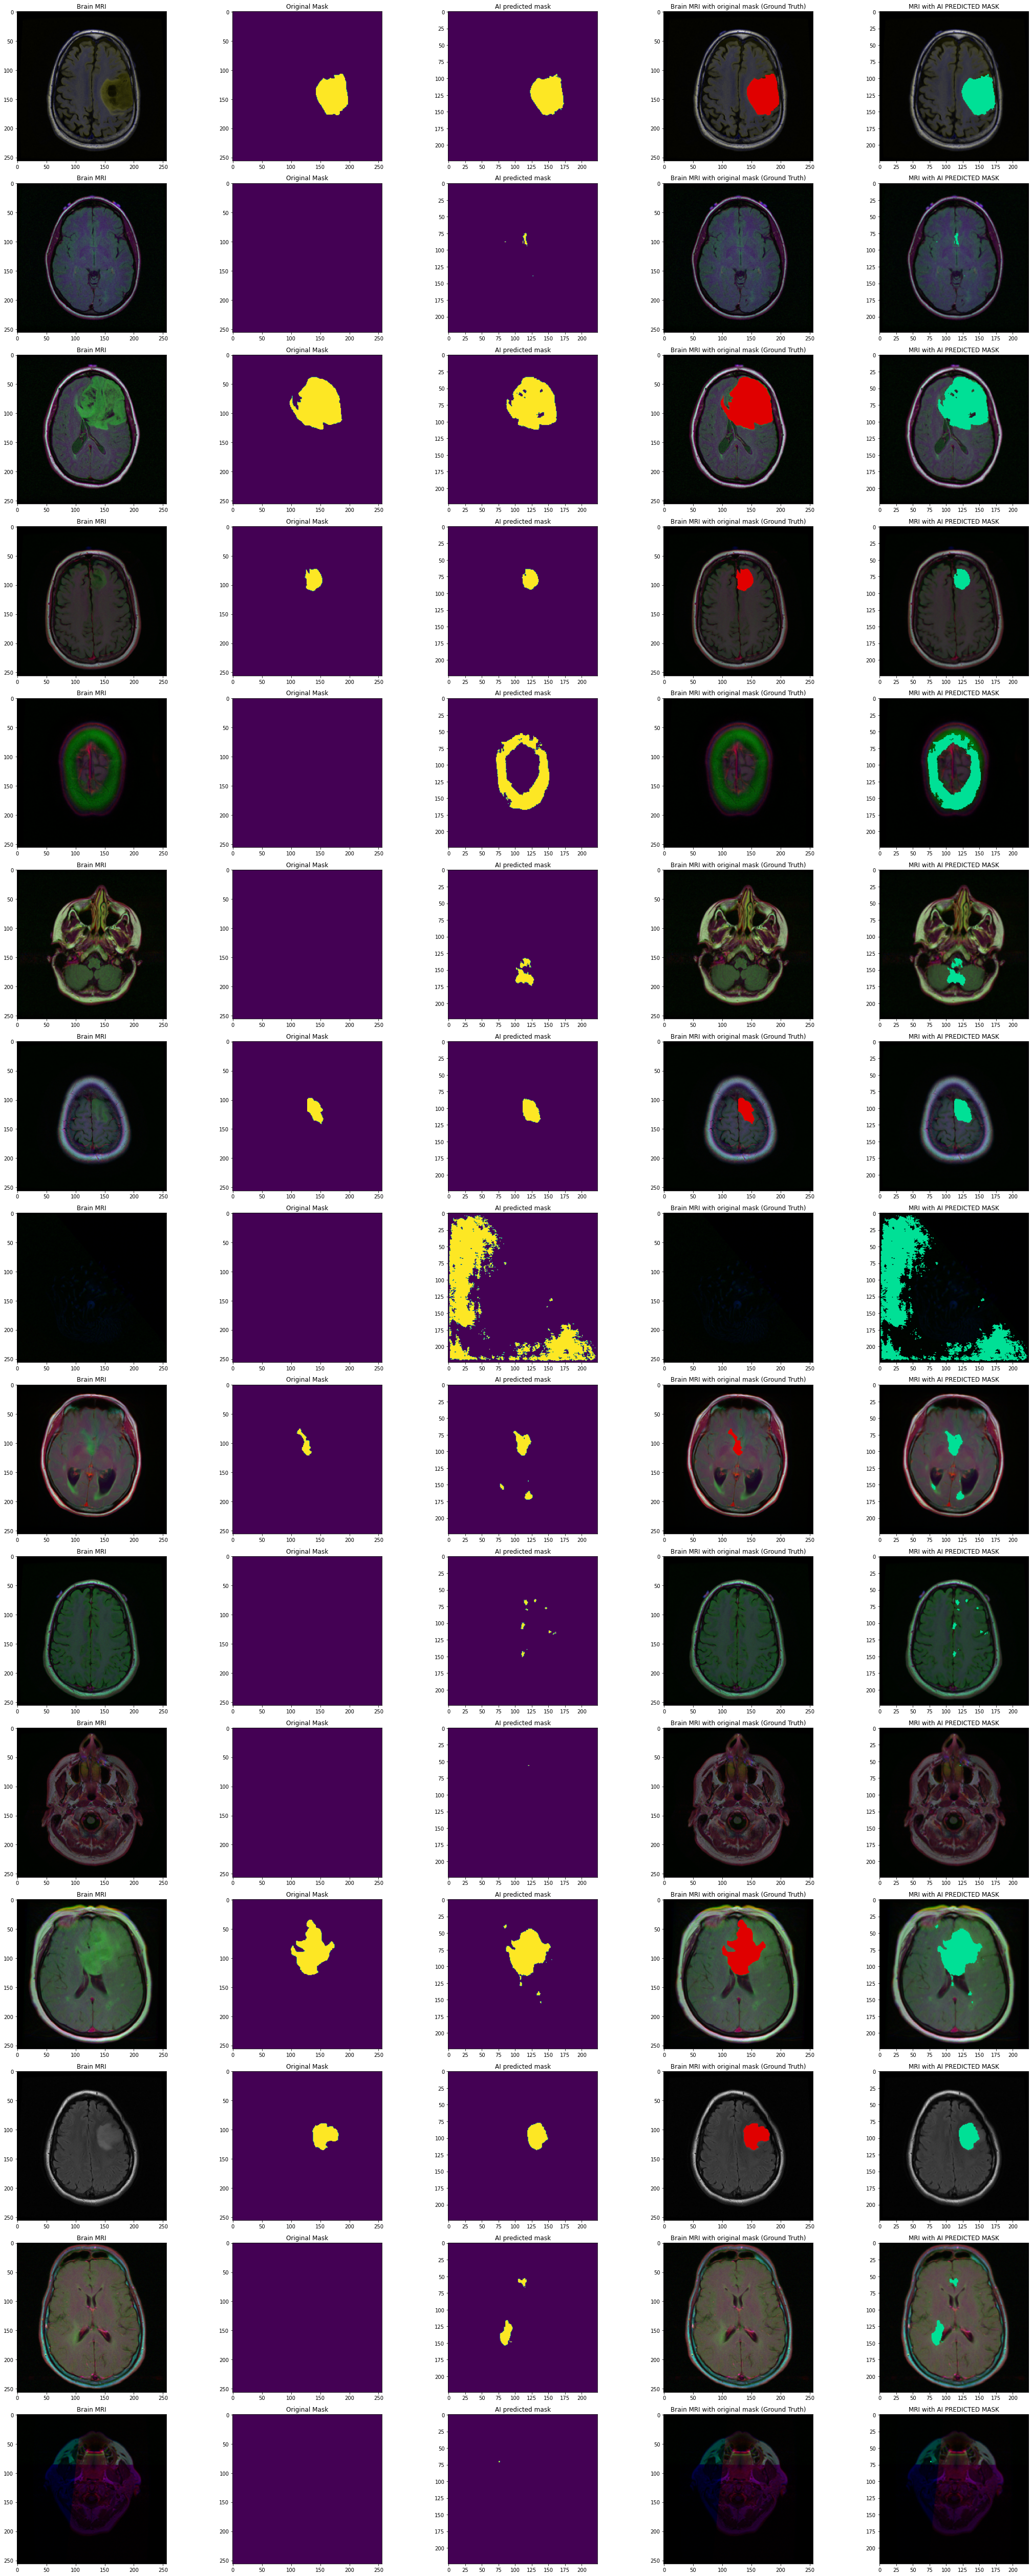

In [27]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (224,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_ =cv2.resize(img_,(224,224))
        img_[pred==1] = (0,224,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()        
